# Nonlinear deterministic generating functions

Perception in a passive agent using linear deterministic generating functions.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from scipy.stats import norm, uniform
from types import SimpleNamespace

mpl.style.use("seaborn-deep")

In this example we examine the difficulties with inverting a model with a nonlinear generating function. We will begin with a deterministic nonlinear generating function first because it clearly illustrates the main concepts. The next notebook will go a step further to examine the same scenario for a probabilistic nonlinear generating function. We will use the same assumptions as the previous examples:
* $x^*$: The true **external state** of the generative process.
* $y$: The **outcome** of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the external states of the generative process ($x^*$) denote the size of a food source and the outcomes ($y$) are represents levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer ("perceive") the hidden state of the generative process that generated the data it is receiving. This is represented by the variable ($x$), the **hidden state** which captures the agent's belief about the food size that could have generated the observed sensory data.

We will assume in this example that food size can be negative, even though this is impossible, to prove a teaching point below.

We begin by defining the environment:
$$
    \mathscr{E} \triangleq  
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* \psi(x^*) & \text{Generating function} \\
        \psi(x^*) = {x^*}^2 & \text{Nonlinear transform of } x^* \\
        \omega_y^* \sim \mathcal{N}(0, \sigma^2=1) & \text{Observation noise} \\
        \theta^* := \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Observation parameters}
    \end{cases}
$$

And the corresponding generative model:
$$
    \mathcal{M} \triangleq  
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; g_{\mathcal{M}}, \sigma^2_y) \approx \delta(x)& \text{Likelihood} \\
        p_{a_x, b_x}(x) = \mathcal{U}(x; a_x, b_x) & \text{Prior on } x \\
        g_{\mathcal{M}}(x; \theta) = \beta_0 + \beta_1 \psi(x) & \text{Generating function} \\
        \psi(x) = x^2 & \text{Nonlinear transform of } x \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \} & \text{Linear parameters} \\
        \phi := \left \{\sigma^2_y \rightarrow 0, a_x = 0, b_x = 5 \right \} & \text{Other parameters} 
    \end{cases}
$$

The generative function is deterministic because we have approximated the variance with a Dirac $\delta$ function. This means $\sigma^2_y \rightarrow 0$. Additionally, the hidden state prior is a uniform distribution which means the agent has no prior assumptions about which hidden states are more likely than any other.

You will also notice here that the generating functions consists of a nonlinear transformation of $x$ (that is still linear in the parameters). Instead of $y = \beta_0 + \beta_1 x$, we instead pass $x$ through a nonlinear transformation function $\psi(x) = x^2$. Although $x$ is nonlinear, the relationship between the parameters is still linear which makes it a linear model. The agent's generating function is visualized below.

In [2]:
x_range = np.linspace(start=-2.5, stop=2.5, num=500)

# Nonlinear transform of x
def phi(x_star: float) -> float:
    return x_star ** 2

def generating_function(beta_0_star: float, beta_1_star: float, x_star: float) -> float:
    return beta_1_star * phi(x_star) + beta_0_star

<Figure size 432x288 with 0 Axes>

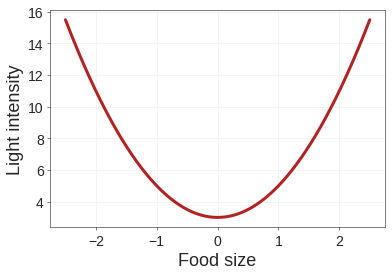

In [3]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

y = generating_function(beta_0_star=3, beta_1_star=2, x_star=x_range)

# Plot linear generating function on canvas
ax.plot(x_range, y,
        c="#b22222",
        linewidth=3)

ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

Now we can create an environment to generate data and an agent to receive this data and perform exact Bayesian inference. Assuming that $x^*=1$, an observation of $y=5$ is generated.

In [4]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def noise(self):
        return np.random.normal(loc=0, scale=self.params.y_star_std)
    
    def phi(self, x_star: float) -> float:
        return x_star**2
    
    def generating_function(self, x_star: float) -> float:
        return self.params.beta_1_star * phi(x_star) + self.params.beta_0_star
    
    def generate(self, x_star: float) -> float:
        return self.generating_function(x_star) + self.noise()
    
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1e-5  # Standard deviation of sensory data
}

# Initialize the environment and support of x
env       = StaticEnvironment(env_params)
x_star    = 1
y         = env.generate(x_star=1)

In [5]:
class StaticAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        self.likelihood = None
        self.prior = None
        
    def phi(self, x: float) -> float:
        return x**2
        
    def generating_function(self):
        return self.params.beta_1 * self.phi(self.params.x_range) + self.params.beta_0
        
    def generative_model(self, y: float):
        self.likelihood = norm.pdf(y, loc=self.generating_function(), scale=self.params.std_y)
        self.prior      = uniform.pdf(self.params.x_range, loc=self.params.ax, scale=self.params.bx-self.params.ax)
        
        return self.likelihood * self.prior
        
    def infer_state(self, y: float):
        gen_model = self.generative_model(y)
        evidence  = np.sum(gen_model, axis=0)
        posterior = gen_model / evidence
        return posterior

In [10]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1e-5  # Standard deviation of sensory data
}

# Agent parameters
agent_params = {
    "beta_0" : 3,              # Linear parameter intercept
    "beta_1" : 2,              # Linear parameter slope
    "std_y"  : float(1./100),  # Likelihood standard deviation
    "ax"     : -2.5,           # Prior uniform lower bound
    "bx"     : 2.5,            # Prior uniform upper bound
    "x_range": np.linspace(start=-2.5, stop=2.5, num=500)
}

In [11]:
# Initialize environment and agent
env       = StaticEnvironment(env_params)
agent     = StaticAgent(agent_params)

# Set true state and generate sensory data
x_star    = 1
y         = env.generate(x_star)

# Perception: Agent infers belief over hidden state using sensory data
posterior = agent.infer_state(y)

# Get likelihood and prior from agent
likelihood = agent.likelihood
prior = agent.prior

<Figure size 432x288 with 0 Axes>

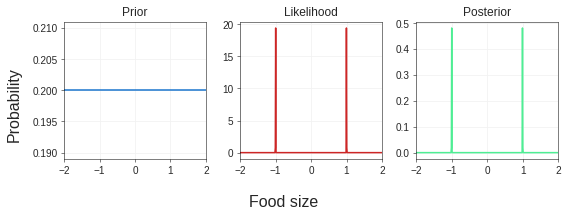

In [12]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.set_xlim([-2, 2])
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

Unfortunately, as we can see here, there are two possible answers due to the nature of this function. The function is *non-bijective* - there is a one-to-many mapping between observations and hidden states. That is, if $y=5$, then this value could be generated when $x=-1$ or $x=1$. Effectively we are saying that $y = 2x^2 + 3$ and trying to solve for $x$. 

Of course we could easily see this by inspecting the plot of the generating function above or by running the generating function for different values of $x$ and show that they produce the same output sensory data:

In [15]:
x_star = 1
y = generating_function(beta_0_star=3, beta_1_star=2, x_star=x_star)
print(f"x_star = {x_star} results in y = {y}")

x_star = -1
y = generating_function(beta_0_star=3, beta_1_star=2, x_star=x_star)
print(f"x_star = {x_star} results in y = {y}")

x_star = 1 results in y = 5
x_star = -1 results in y = 5


Without further information this problem the agent will not be able to properly invert this function since it has more than one solution. In Bayesian inference the constraint can be encoded in terms of the **prior**. If we encode the fact that negative food sizes have a zero probability then we will effectively constrain the inference process to the domain of $x \geq 0$. Below we change the support of the uniform distribution to the range $0.01 \leq x \lt 500$ by modifying the upper and lower bounds of the distribution.

In [18]:
# Agent parameters
agent_params = {
    "beta_0" : 3,              # Linear parameter intercept
    "beta_1" : 2,              # Linear parameter slope
    "std_y"  : float(1./100),  # Likelihood standard deviation
    "ax"     : 0.01,           # Prior uniform lower bound
    "bx"     : 500,            # Prior uniform upper bound
    "x_range": np.linspace(start=-2.5, stop=2.5, num=500)
}

Running the agent and environment again we can see the following:

In [19]:
# Initialize environment and agent
env       = StaticEnvironment(env_params)
agent     = StaticAgent(agent_params)

# Set true state and generate sensory data
x_star    = 1
y         = env.generate(x_star)

# Perception: Agent infers belief over hidden state using sensory data
posterior = agent.infer_state(y)

# Get likelihood and prior from agent
likelihood = agent.likelihood
prior = agent.prior

<Figure size 432x288 with 0 Axes>

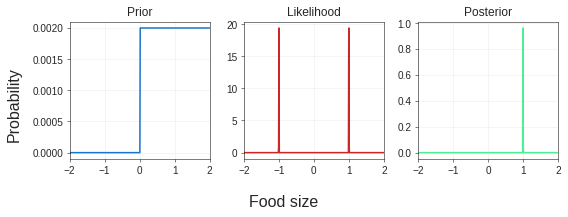

In [20]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.set_xlim([-2, 2])
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

Since values of $x$ less than zero have a zero probability the posterior is constrained so that $x=1$ is the most probable food size to have generated the light intensity $y=5$.